# NBA Game Outcome Prediction Project

## Introduction

For my project, I wanted to analyze NBA game data to build predictive models that can determine game outcomes based on in-game statistics. The dataset I'm using provides detailed "snapshots" of games at regular time intervals, tracking the score, time remaining, and other metrics throughout each game. 

As a basketball fan, I've always been fascinated by the concept of win probability and how it fluctuates during games. Commentators often discuss how certain moments are "turning points" in games, but I wanted to explore this analytically. My goal is to determine how accurately we can predict the final outcome of an NBA game based on the state of the game at various time points, and to identify which factors are most important in making these predictions.

## Primary Goals

1. Build machine learning models that can accurately predict which team will win an NBA game based on in-game statistics like score differential, time remaining, period, and other features in my dataset.

2. Analyze how win probability evolves throughout games and determine at what point in games predictions become reliable.

3. Compare the performance of different machine learning approaches (logistic regression, random forests, gradient boosting, etc) to see which works best for this prediction task.

4. Identify key moments or thresholds during games that have the strongest correlation with final outcomes - essentially finding the statistical "point of no return" in NBA games.

I believe this analysis will provide interesting insights into basketball game dynamics and potentially reveal patterns that aren't obvious to casual observers of the game.

![JAMES WITH THE SLAM!](../../images/lebron-dunk-lebron-james.gif)

# Data Source and Citation
For my project, I collected NBA game data using the nba_api Python package, which provides direct accest to NBA.com's official statistics. I collected the raw data the dataset I'm using was configured to contain a season's worth of NBA game snapshots with numerous features (reference codebook.md)


### Formal Citation:
Swar, S. (2018). nba_api: An API Client package to access NBA.com endpoints. Available from https://github.com/swar/nba_api
Link to Source:
https://github.com/swar/nba_api


### Importing & Cleaning Data

In [ ]:
import pandas as pd

games_2022_2023 = pd.read_csv("../../data/revised_nba_2022_23_all_games_snapshots.csv")
for column in games_2022_2023.columns:
    print(f"Column {column} has {games_2022_2023[column].isna().sum()} missing values")

overtime_games = games_2022_2023[games_2022_2023['PERIOD'] == 5]['GAME_ID'].unique()
df_filtered = games_2022_2023[~games_2022_2023['GAME_ID'].isin(overtime_games)]

# Verify the result
print(f"Original dataset size: {len(games_2022_2023)}")
print(f"Number of overtime games removed: {len(overtime_games)}")
print(f"Filtered dataset size: {len(df_filtered)}")

for column in df_filtered.columns:  # Changed this line
    print(f"Column {column} has {df_filtered[column].isna().sum()} missing values")

# Adding features to the FILTERED dataset
# Sort the dataframe to ensure proper ordering
df_filtered = df_filtered.sort_values(['GAME_ID', 'seconds_elapsed'])  # Changed this line

# 1. Calculate momentum: change in score differential over last 2 minutes (4 snapshots back)
df_filtered['MOMENTUM'] = df_filtered.groupby('GAME_ID')['SCORE_DIFF'].diff(periods=4)  # Changed this line

# Fill NaN values (first 4 snapshots of each game) with 0
df_filtered['MOMENTUM'] = df_filtered['MOMENTUM'].fillna(0)  # Changed this line

df_filtered.to_csv("../../data/new_nba_2022_23_all_games_snapshots.csv", index=False)  # Changed this line

Column seconds_elapsed has 0 missing values
Column GAME_ID has 0 missing values
Column PERIOD has 0 missing values
Column AWAY_SCORE has 1792 missing values
Column HOME_SCORE has 1792 missing values
Column SCORE_DIFF has 1792 missing values
Column IS_HOME_LEADING has 1792 missing values
Column HOME_TEAM_WIN_PCT has 1792 missing values
Column AWAY_TEAM_WIN_PCT has 1792 missing values
Column HOME_TEAM_WON has 1792 missing values
Column HOME_TEAM has 1792 missing values
Column AWAY_TEAM has 1792 missing values
Column PCTIMESTRING has 0 missing values
Original dataset size: 174200
Number of overtime games removed: 79
Filtered dataset size: 159500
Column seconds_elapsed has 0 missing values
Column GAME_ID has 0 missing values
Column PERIOD has 0 missing values
Column AWAY_SCORE has 0 missing values
Column HOME_SCORE has 0 missing values
Column SCORE_DIFF has 0 missing values
Column IS_HOME_LEADING has 0 missing values
Column HOME_TEAM_WIN_PCT has 0 missing values
Column AWAY_TEAM_WIN_PCT ha

### Read in the new data

In [8]:
nba_games_2022_2023 = pd.read_csv("../../data/new_nba_2022_23_all_games_snapshots.csv")
nba_games_2022_2023.head()

,seconds_elapsed,GAME_ID,PERIOD,AWAY_SCORE,HOME_SCORE,SCORE_DIFF,IS_HOME_LEADING,HOME_TEAM_WIN_PCT,AWAY_TEAM_WIN_PCT,HOME_TEAM_WON,HOME_TEAM,AWAY_TEAM,PCTIMESTRING,MOMENTUM
0,0,22200001,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Boston Celtics,Philadelphia 76ers,12:00,0.0
1,0,22200001,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Boston Celtics,Philadelphia 76ers,12:00,0.0
2,30,22200001,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Boston Celtics,Philadelphia 76ers,11:30,0.0
3,30,22200001,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Boston Celtics,Philadelphia 76ers,11:30,0.0
4,60,22200001,1,2.0,2.0,0.0,0.0,1.0,0.0,1.0,Boston Celtics,Philadelphia 76ers,11:00,0.0


## Handling Missing Values

    Handling Missing Values in Overtime Games:
Upon initial exploration, I identified 1,792 missing values in my dataset's scoring-related features. Further investigation revealed a systematic pattern: these missing values occurred exclusively in overtime periods (specifically when games reached a 5th period).
The missing data spans from the 12:00 to 5:30 mark (minutes and seconds remaining) or equivalently from the 0 to 390th second mark of overtime periods. This pattern exists because NBA overtime periods are only 5 minutes long, rather than the standard 12 minutes of regular quarters.
Since overtime games constitute a relatively small proportion of my dataset, there aren't enough unique overtime period snapshots to enable reliable model training for these scenarios. Therefore, to maintain data consistency and model reliability, I decided to exclude all overtime games from my analysis. This approach allows me to focus on regulation-time game dynamics while eliminating the missing value issue entirely, rather than implementing imputation methods that might introduce bias into the overtime period data.

## Exploratory Data Analysis

    Correlation Matrix:

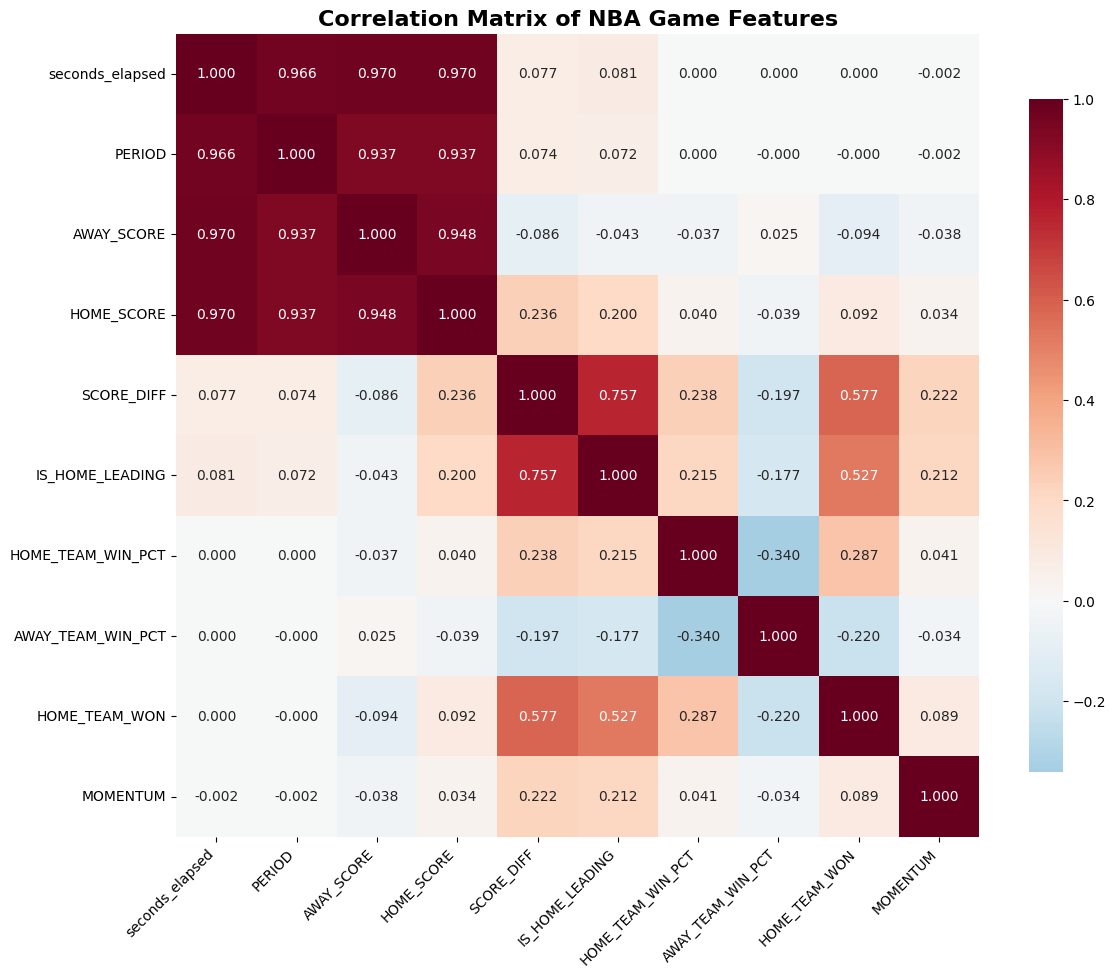


Correlations with HOME_TEAM_WON (target variable):
SCORE_DIFF: 0.577
IS_HOME_LEADING: 0.527
HOME_TEAM_WIN_PCT: 0.287
AWAY_TEAM_WIN_PCT: -0.220
AWAY_SCORE: -0.094
HOME_SCORE: 0.092
MOMENTUM: 0.089
seconds_elapsed: 0.000
PERIOD: -0.000

Potential multicollinearity issues (|correlation| > 0.7):
seconds_elapsed vs PERIOD: 0.966
seconds_elapsed vs AWAY_SCORE: 0.970
seconds_elapsed vs HOME_SCORE: 0.970
PERIOD vs AWAY_SCORE: 0.937
PERIOD vs HOME_SCORE: 0.937
AWAY_SCORE vs HOME_SCORE: 0.948
SCORE_DIFF vs IS_HOME_LEADING: 0.757


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_features = [
    'seconds_elapsed', 'PERIOD', 'AWAY_SCORE', 'HOME_SCORE', 
    'SCORE_DIFF', 'IS_HOME_LEADING', 'HOME_TEAM_WIN_PCT', 
    'AWAY_TEAM_WIN_PCT', 'HOME_TEAM_WON', 'MOMENTUM'
]


correlation_matrix = nba_games_2022_2023[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, \
            square=True,  
            fmt='.3f',
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Matrix of NBA Game Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with target variable (HOME_TEAM_WON)
print("\nCorrelations with HOME_TEAM_WON (target variable):")
target_correlations = correlation_matrix['HOME_TEAM_WON'].sort_values(key=abs, ascending=False)
for feature, corr in target_correlations.items():
    if feature != 'HOME_TEAM_WON':
        print(f"{feature}: {corr:.3f}")

print("\nPotential multicollinearity issues (|correlation| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            print(f"{feature1} vs {feature2}: {corr_val:.3f}")

## Target Variable Predictors (HOME_TEAM_WON)
    Strong Predictors:

SCORE_DIFF (0.577) - The strongest predictor, confirming that current score differential is highly indicative of final outcome
IS_HOME_LEADING (0.527) - Nearly as strong, showing that simply being ahead is a powerful predictor

    Moderate Predictors:

HOME_TEAM_WIN_PCT (0.287) - Team quality matters, with better home teams more likely to win
AWAY_TEAM_WIN_PCT (-0.220) - Inverse relationship as expected; stronger away teams reduce home team win probability

    Weak Predictors:

HOME_SCORE/AWAY_SCORE (0.092/-0.094) - Raw scores matter less than the differential
MOMENTUM (0.089) - Surprisingly weak, suggesting recent scoring trends are less predictive than current game state
seconds_elapsed/PERIOD (≈0.000) - Time itself has virtually no correlation with outcome

    Critical Multicollinearity Issues
Severe Problems (>0.9 correlation):

Time variables: seconds_elapsed vs PERIOD (0.966) - These measure the same thing
Score progression: Both scores correlate 0.97+ with time, indicating scores naturally increase as games progress
Score relationship: AWAY_SCORE vs HOME_SCORE (0.948) - Games tend to have similar total scoring

    Moderate Problem:

SCORE_DIFF vs IS_HOME_LEADING (0.757) - Logically connected but not perfectly correlated due to tied games

    Win Probability Evolution Plot

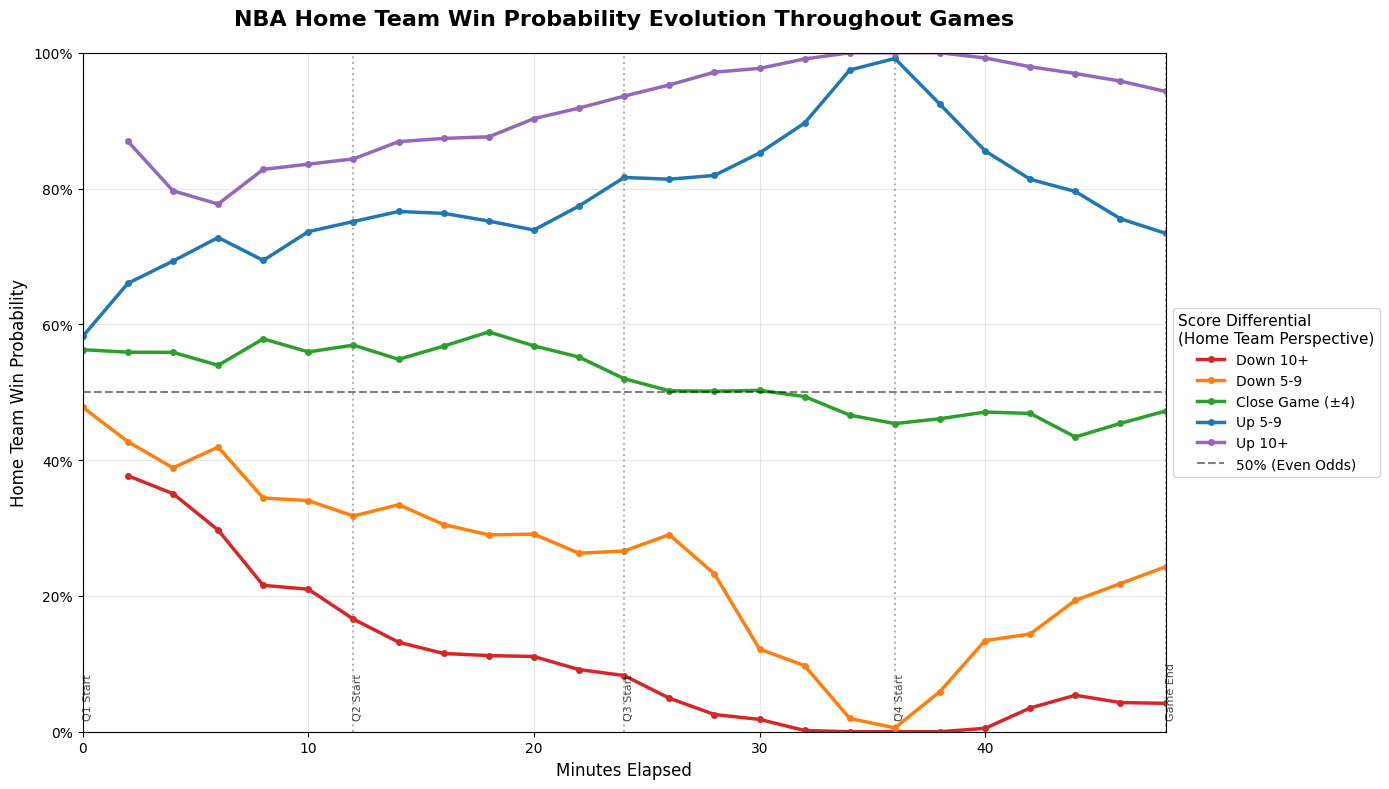

Key Insights from Win Probability Evolution:


In [ ]:
def categorize_score_diff(score_diff):
    if score_diff <= -10:
        return "Down 10+"
    elif score_diff <= -5:
        return "Down 5-9"
    elif -4 <= score_diff <= 4:
        return "Close Game (±4)"
    elif score_diff <= 9:
        return "Up 5-9"
    else:
        return "Up 10+"

df_filtered['SCORE_CATEGORY'] = df_filtered['SCORE_DIFF'].apply(categorize_score_diff)
df_filtered['TIME_BIN'] = (df_filtered['seconds_elapsed'] // 120) * 120

win_prob_data = []

for time_bin in sorted(df_filtered['TIME_BIN'].unique()):
    for category in ["Down 10+", "Down 5-9", "Close Game (±4)", "Up 5-9", "Up 10+"]:
        subset = df_filtered[
            (df_filtered['TIME_BIN'] == time_bin) & 
            (df_filtered['SCORE_CATEGORY'] == category)
        ]
        
        if len(subset) > 0: 
            win_rate = subset['HOME_TEAM_WON'].mean()
            sample_size = len(subset)
            
            win_prob_data.append({
                'time_bin': time_bin,
                'category': category,
                'win_probability': win_rate,
                'sample_size': sample_size,
                'minutes_elapsed': time_bin / 60
            })

win_prob_df = pd.DataFrame(win_prob_data)

plt.figure(figsize=(14, 8))
colors = {
    "Down 10+": "#d62728",      # Red
    "Down 5-9": "#ff7f0e",      # Orange  
    "Close Game (±4)": "#2ca02c", # Green
    "Up 5-9": "#1f77b4",        # Blue
    "Up 10+": "#9467bd"         # Purple
}

for category in ["Down 10+", "Down 5-9", "Close Game (±4)", "Up 5-9", "Up 10+"]:
    category_data = win_prob_df[win_prob_df['category'] == category]
    
    plt.plot(category_data['minutes_elapsed'], 
             category_data['win_probability'],
             marker='o', 
             linewidth=2.5,
             markersize=4,
             label=category,
             color=colors[category])


plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='50% (Even Odds)')
plt.title('NBA Home Team Win Probability Evolution Throughout Games', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Minutes Elapsed', fontsize=12)
plt.ylabel('Home Team Win Probability', fontsize=12)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid(True, alpha=0.3)

plt.legend(title='Score Differential\n(Home Team Perspective)', 
           title_fontsize=11,
           fontsize=10,
           loc='center left',
           bbox_to_anchor=(1, 0.5))

plt.xlim(0, 48)
plt.ylim(0, 1)

quarter_times = [0, 12, 24, 36, 48]
quarter_labels = ['Q1 Start', 'Q2 Start', 'Q3 Start', 'Q4 Start', 'Game End']
for time, label in zip(quarter_times, quarter_labels):
    plt.axvline(x=time, color='gray', linestyle=':', alpha=0.6)
    plt.text(time, 0.02, label, rotation=90, fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()